# KPP test stand efficiency analysis 

In [1]:
# External libraries
import sys
# import numpy as np
# import uproot
import awkward as ak
# import matplotlib.pyplot as plt
# from concurrent.futures import ThreadPoolExecutor

# Mu2e pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyprint 
import pyplot 

pr = pyprint.Print()
pl = pyplot.Plot()

# anapytools
from anapytools.read_data import DataReader
reader = DataReader()

# EffAna methods
sys.path.append("../Utils")
from processor import Processor # process rec trees into ak
from crvaging019 import CrvAging019 # get PEs/layer for crvaging-019
from cuts import Cuts # Apply cuts
from trigger import Trigger # Trigger
from sort import Sort # Sort PEs / layer
from histogrammer import Histogrammer # Accumulate histograms 
from scan_inefficiency import ScanInefficiency # Scan inefficiency

## Process data

In [2]:
# Initialise
reader = DataReader()
processor = Processor(reader=reader)

# Configure dataset
defname = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.root"
run_number="002101"

# Get filelist
filelist = processor.get_filelist(defname, run_number)

# Process files
arrays = processor.process_files_parallel(filelist)

# Print array info
arrays.type.show()
print("\n → FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print(" → Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

---> Loading Processor...
filelist: ['rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_002.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root']

---> Starting parallel processing with 5 workers...
Processing 5 files in total

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root processed successfully!
  → Events in this file: 154878
  → Progress: 1/5 files (20.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root processed successfully!
  → Events in this file: 156933
  → Progress: 2/5 files (40.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root processed successfully!
  → Events in this file: 157287
  → Progress: 3/5 files (60.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root processed succe

## Get PEs/layer

In [3]:
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T()
arrays = crvaging019.crv_DS()
print()
arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...

---> Mapping CRV-L-end
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

773205 * {
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    subrun: int64,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 1.25, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
subrun: 3
PEs_per_layer_L_end: [[0, 0, 0.617, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0.866, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_DS: [[0, 

## Apply cuts


---> Loading Cuts...
Initial number of events: 773205


/home/sgrant/Wideband/Notebooks/../EventNtuple/utils/pyutils/pyplot.py:187: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin, xmax)


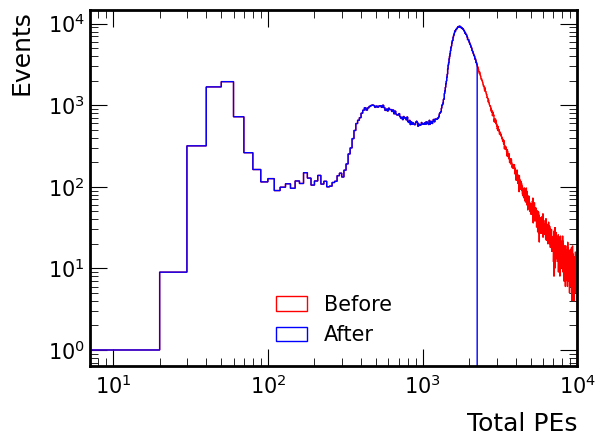


Total PE cut (< 2250):
Events removed: 164394 (21.3%)
Events remaining: 608811 (78.7% of initial)


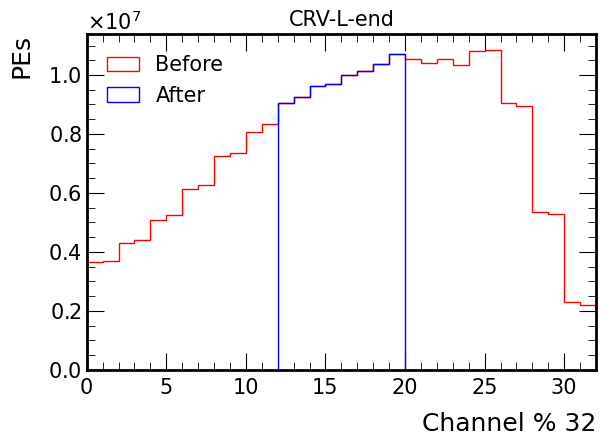


Fiducial cut (channels 12-19):


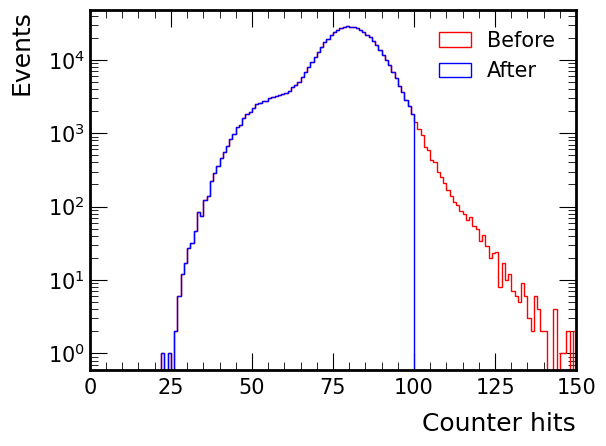


Counters hit cut (≤ 100):
Events removed: 7537 (1.2%)
Events remaining: 601274 (77.8% of initial)


In [4]:
cuts = Cuts(arrays, verbose=True)

max_PEs = 2250
# 0,1,2,3 4,5,6,7 8,9,10,11 12,13,14,15 16,17,18,19 20,21,22,23 24,25,26,27, 28,29,30,31
lo_chan=12
hi_chan=19
min_counter_hits=8*2
max_counter_hits=100

arrays = cuts.tot_PE_cut(max_PEs=max_PEs)
arrays = cuts.fiducial_cut(lo_chan=lo_chan, hi_chan=hi_chan) 
arrays = cuts.counters_hit_cut(min_counter_hits=min_counter_hits, max_counter_hits=max_counter_hits)

## Trigger

In [6]:
# Initiliase
trigger = Trigger(arrays)
# Find triggers
arrays = trigger.get_triggers()
# Apply triggers
arrays = trigger.apply_triggers()

---> Loading Trigger...
---> Triggering
-> 69958/601274 = 11.63% events have triggers


## Sort PEs in test module

In [8]:
sort = Sort()
arrays["PEs_per_layer_T_sorted"] = sort.sort_layer_PEs(arrays['PEs_per_layer_T'])
sort.print_sorted_layer_PEs(arrays['PEs_per_layer_T_sorted'])

---> Loading Sort...
Sorted PEs:
0 [79.9, 95.6, 104, 127]
1 [84.9, 104, 105, 106]
2 [79, 81.9, 95.1, 96.4]
3 [74, 91.3, 132, 161]
4 [94.1, 122, 135, 264]
5 [106, 119, 127, 144]
6 [91.2, 139, 179, 218]
7 [95.1, 122, 132, 187]
8 [74.7, 84.5, 96.5, 129]
9 [92.5, 101, 152, 174]
...


---> Loading Hists...


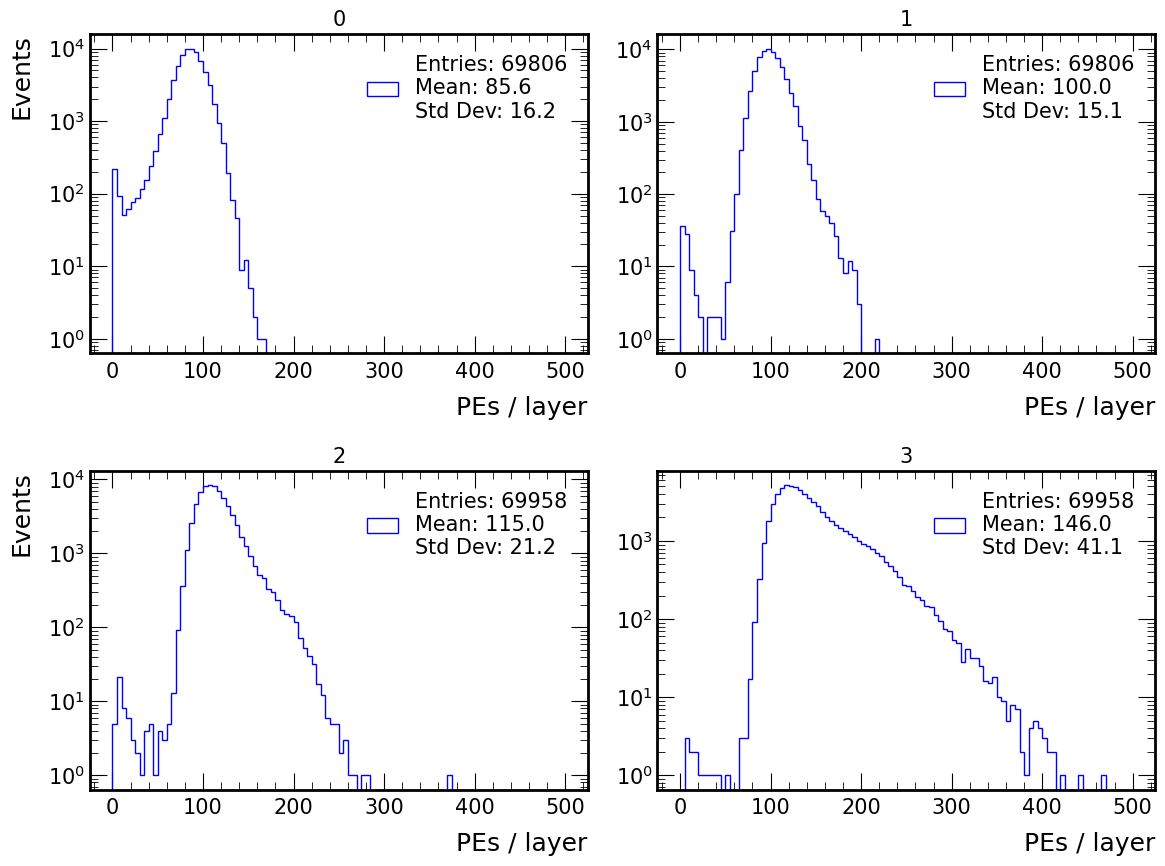

In [9]:
histogrammer = Histogrammer()
hists = histogrammer.acc_hists(arrays)
histogrammer.plot_hists(hists)

## Scan inefficiency 

---> Loading Inefficiency...
PE thresholds to scan:
[ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145.
 150.]


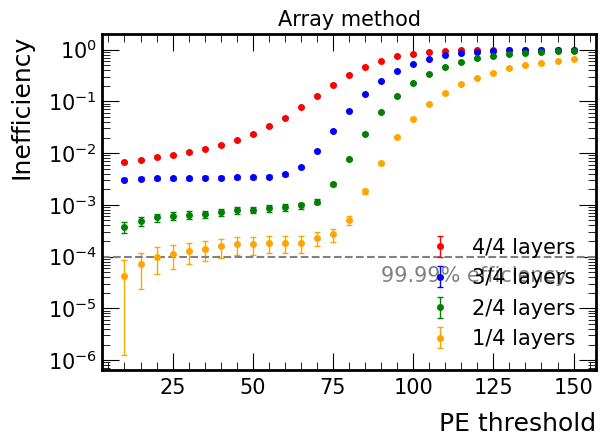

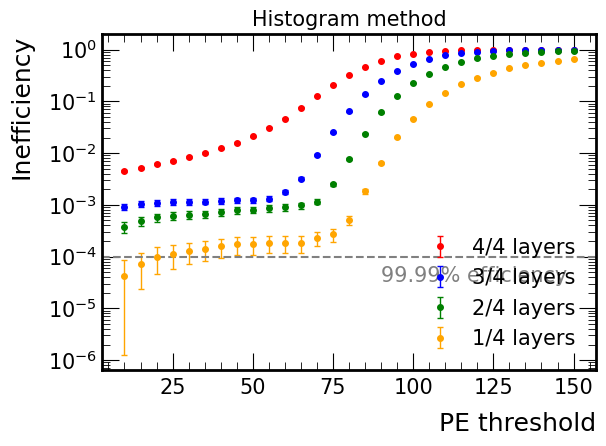

In [11]:
inefficiency = ScanInefficiency()

# Array method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_arrays(arrays)
inefficiency.plot_scan(ineff, ineff_err, title="Array method")

# Histogram method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
inefficiency.plot_scan(ineff, ineff_err, title="Histogram method")